In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets
# 모델 요약
from torchvision import models, utils
from torchsummary import summary

In [2]:
# 학습률, batch, epoch
lr = 1e-3
batch_size = 64
num_epoch = 10

# 학습된 network가 저장될 디렉터리
ckpt_dir = 'D:/torchtorch/checkpoint4'
# 텐서보드 파일이 저장될 디렉터리
log_dir = 'D:/torchtorch/log4'
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 네트워크 구축
class Fashion_MNIST_NET(nn.Module) :
    def __init__(self) :
        super(Fashion_MNIST_NET, self).__init__()
        
        # 입력채널 : gray scale이므로 1, 출력 채널(=필터 개수)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        # 32x28x28
        self.batch1 = nn.BatchNorm2d(32)
        # 32x28x28
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 32x14x14
        
        # 입력채널 : 이전 채널의 출력 개수, 출력 채널(=필터 개수)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
#         self.drop2 = nn.Dropout2d(p=0.5)
        self.batch2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        # 64x14x14
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # 64x7x7
        
        # Global Average Pooling 뒤에 FC와 연결
        self.avg_pool = nn.AvgPool2d(1)
        
        self.fc1 = nn.Linear(in_features=3136, out_features=100)
        self.drop1 = nn.Dropout2d(p=0.5)
        
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        # 입력 채널 : 이전 채널의 출력 개수, 마지막층 출력 = 분류하려는 class 개수
        self.fc3 = nn.Linear(in_features=50, out_features=10, bias=True)
     
    # 앞에서 초기화 한 layer들을 연결해준다.
    def forward(self, x) :
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)
        x = self.pool2(x)
       
        x = self.avg_pool(x)
        # Flatten() -> 입력 채널 맞춰줘야함
        x = x.view(-1, 3136)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [4]:
## 네트워크를 저장하거나 불러오는 함수 작성하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               '%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])

    return net, optim

In [5]:
## MNIST 데이터 불러오기
## 이미지 전처리 과정
# 1. 이미지 텐서 변환 및 정규화 등 수행(.Compose) 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

# 2. 데이터셋 불러오기
dataset = datasets.FashionMNIST(download=True, root='./.data/', train=True, transform=transform)

# 3. 데이터셋 나누기
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# 4. 1배치에 들어갈 데이터 
# 1epoch = 60000개 = 64batch
# 1batch = 60000/64(batch_size) = 938
num_data = len(loader.dataset)
num_batch = np.ceil(num_data / batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([5, 0, 5, 4, 1, 2, 1, 5, 7, 4, 0, 9, 9, 3, 8, 9, 5, 0, 2, 9, 4, 6, 0, 3,
        1, 2, 7, 9, 2, 3, 5, 0, 3, 6, 0, 2, 6, 2, 5, 8, 5, 1, 1, 3, 9, 8, 4, 4,
        4, 9, 2, 5, 4, 4, 4, 3, 9, 1, 9, 1, 2, 0, 9, 4])


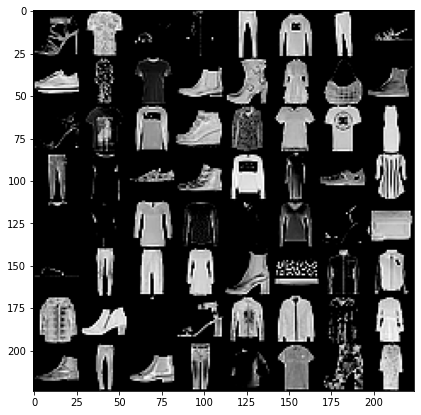

In [6]:
## 데이터셋 시각화하기
# 배치 1개의 image와 label 들을 확인해보기(64개 이미지 존재)
dataiter = iter(loader)
images, labels = next(dataiter)
# 시각화 하기
img = utils.make_grid(images, padding=0)
# 원래 이미지 -> 64개(1epoch, channel, height, width)
print(images.shape)
print(labels.shape)
print(labels)
npimg = img.numpy()
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [7]:
# 클래스 딕셔너리로 만들기
CLASSES = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}
# labels 는 0부터 9까지의 숫자로 이루어져 있다.
# 이를 CLASSES에 있는 index와 일치시킨다.
print(labels)
for label in labels :
    index = label.item()
    print(CLASSES[index])

tensor([5, 0, 5, 4, 1, 2, 1, 5, 7, 4, 0, 9, 9, 3, 8, 9, 5, 0, 2, 9, 4, 6, 0, 3,
        1, 2, 7, 9, 2, 3, 5, 0, 3, 6, 0, 2, 6, 2, 5, 8, 5, 1, 1, 3, 9, 8, 4, 4,
        4, 9, 2, 5, 4, 4, 4, 3, 9, 1, 9, 1, 2, 0, 9, 4])
Sandal
T-shirt/top
Sandal
Coat
Trouser
Pullover
Trouser
Sandal
Sneaker
Coat
T-shirt/top
Ankle boot
Ankle boot
Dress
Bag
Ankle boot
Sandal
T-shirt/top
Pullover
Ankle boot
Coat
Shirt
T-shirt/top
Dress
Trouser
Pullover
Sneaker
Ankle boot
Pullover
Dress
Sandal
T-shirt/top
Dress
Shirt
T-shirt/top
Pullover
Shirt
Pullover
Sandal
Bag
Sandal
Trouser
Trouser
Dress
Ankle boot
Bag
Coat
Coat
Coat
Ankle boot
Pullover
Sandal
Coat
Coat
Coat
Dress
Ankle boot
Trouser
Ankle boot
Trouser
Pullover
T-shirt/top
Ankle boot
Coat


In [8]:
## 네트워크 설정 및 필요한 손실함수 구현하기
from torch.optim import lr_scheduler
net = Fashion_MNIST_NET().to(device)
params = net.parameters()

fn_loss = nn.CrossEntropyLoss().to(device)
fn_pred = lambda output: torch.softmax(output, dim=1)
fn_acc = lambda pred, label: ((pred.max(dim=1)[1] == label).type(torch.float)).mean()

optim = torch.optim.Adam(params, lr=lr)
# mode='max': accuracy, 'min' : loss 탐색
scheduler = lr_scheduler.ReduceLROnPlateau(optim,verbose=True)

## early stopping condition 정의
n_epochs_stop = 10
epochs_no_improve = 0
early_stop = False
min_val_loss = np.Inf

writer = SummaryWriter(log_dir=log_dir)

In [11]:
## 모델 요약
print(summary(net, (1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
         AvgPool2d-9             [-1, 64, 7, 7]               0
           Linear-10                  [-1, 100]         313,700
        Dropout2d-11                  [-1, 100]               0
           Linear-12                   [-1, 50]           5,050
           Linear-13                   [-1, 10]             510
Total params: 338,268
Trainable params:

In [10]:
## 트레이닝 시작하기
st_epoch = 0
for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train()

    loss_arr = []
    acc_arr = []

    for  batch, (input, label) in enumerate(loader, 1):
        
        input = input.to(device)
        # input shape = (batch, channel, height, width)
#         print(input.shape)
        
        label = label.to(device)
        # label shape = (batch)
#         print(label.shape)
        
        output = net(input)
        # output shape = (batch, 10)
#         print(output.shape)
        
        # pred shape = (batch, 10)
        pred = fn_pred(output)
#         print(pred.shape)
        
        # 모든 model parameter의 gradient를 0으로 설정한다.(epoch마다 새롭게, loss 증가 방지)
        optim.zero_grad()

        # loss와 acc를 계산
        loss = fn_loss(output, label)
        acc = fn_acc(pred, label)
    
        # loss와 chain rule를 통해 각 layer의 gradient를 계산한다.
        loss.backward()
        
        # parameter를 update한다.
        optim.step()

        loss_arr += [loss.item()]
        acc_arr += [acc.item()]

        print('TRAIN: EPOCH %04d/%04d | BATCH %04d/%04d | LOSS: %.4f | ACC %.4f' %
              (epoch, num_epoch, batch, num_batch, np.mean(loss_arr), np.mean(acc_arr)))
        scheduler.step(np.mean(loss_arr))
        
        # loss가 향상되지 않았다면 count를 증가시킨다.
        if np.mean(loss_arr) < min_val_loss :
            epochs_no_improve = 0
            min_val_loss = np.mean(loss_arr)
        else :
            epochs_no_improve += 1
        # 만약 향상되지 않은 count가 지정한 횟수에 도달하면 빠져나간다.
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            print("Stopped")
            break
        else:
            continue
            
    writer.add_scalar('loss', np.mean(loss_arr), epoch)
    writer.add_scalar('acc', np.mean(acc_arr), epoch)

    save(ckpt_dir = ckpt_dir, net=net, optim=optim, epoch=epoch)

writer.close()

TRAIN: EPOCH 0001/0010 | BATCH 0001/0938 | LOSS: 2.3039 | ACC 0.1094
TRAIN: EPOCH 0001/0010 | BATCH 0002/0938 | LOSS: 2.6269 | ACC 0.1484
TRAIN: EPOCH 0001/0010 | BATCH 0003/0938 | LOSS: 2.4173 | ACC 0.1927
TRAIN: EPOCH 0001/0010 | BATCH 0004/0938 | LOSS: 2.2560 | ACC 0.2344
TRAIN: EPOCH 0001/0010 | BATCH 0005/0938 | LOSS: 2.1770 | ACC 0.2437
TRAIN: EPOCH 0001/0010 | BATCH 0006/0938 | LOSS: 2.1473 | ACC 0.2604
TRAIN: EPOCH 0001/0010 | BATCH 0007/0938 | LOSS: 2.0689 | ACC 0.2924
TRAIN: EPOCH 0001/0010 | BATCH 0008/0938 | LOSS: 1.9792 | ACC 0.3125
TRAIN: EPOCH 0001/0010 | BATCH 0009/0938 | LOSS: 1.8997 | ACC 0.3316
TRAIN: EPOCH 0001/0010 | BATCH 0010/0938 | LOSS: 1.8108 | ACC 0.3625
TRAIN: EPOCH 0001/0010 | BATCH 0011/0938 | LOSS: 1.7425 | ACC 0.3878
TRAIN: EPOCH 0001/0010 | BATCH 0012/0938 | LOSS: 1.6905 | ACC 0.4010
TRAIN: EPOCH 0001/0010 | BATCH 0013/0938 | LOSS: 1.6382 | ACC 0.4171
TRAIN: EPOCH 0001/0010 | BATCH 0014/0938 | LOSS: 1.5832 | ACC 0.4364
TRAIN: EPOCH 0001/0010 | BATCH 001

TRAIN: EPOCH 0001/0010 | BATCH 0120/0938 | LOSS: 0.7644 | ACC 0.7280
TRAIN: EPOCH 0001/0010 | BATCH 0121/0938 | LOSS: 0.7612 | ACC 0.7295
TRAIN: EPOCH 0001/0010 | BATCH 0122/0938 | LOSS: 0.7602 | ACC 0.7300
TRAIN: EPOCH 0001/0010 | BATCH 0123/0938 | LOSS: 0.7570 | ACC 0.7311
TRAIN: EPOCH 0001/0010 | BATCH 0124/0938 | LOSS: 0.7574 | ACC 0.7307
TRAIN: EPOCH 0001/0010 | BATCH 0125/0938 | LOSS: 0.7551 | ACC 0.7311
TRAIN: EPOCH 0001/0010 | BATCH 0126/0938 | LOSS: 0.7526 | ACC 0.7321
TRAIN: EPOCH 0001/0010 | BATCH 0127/0938 | LOSS: 0.7517 | ACC 0.7324
TRAIN: EPOCH 0001/0010 | BATCH 0128/0938 | LOSS: 0.7511 | ACC 0.7323
TRAIN: EPOCH 0001/0010 | BATCH 0129/0938 | LOSS: 0.7484 | ACC 0.7334
TRAIN: EPOCH 0001/0010 | BATCH 0130/0938 | LOSS: 0.7457 | ACC 0.7346
TRAIN: EPOCH 0001/0010 | BATCH 0131/0938 | LOSS: 0.7440 | ACC 0.7351
TRAIN: EPOCH 0001/0010 | BATCH 0132/0938 | LOSS: 0.7429 | ACC 0.7354
TRAIN: EPOCH 0001/0010 | BATCH 0133/0938 | LOSS: 0.7402 | ACC 0.7367
TRAIN: EPOCH 0001/0010 | BATCH 013

TRAIN: EPOCH 0001/0010 | BATCH 0241/0938 | LOSS: 0.6291 | ACC 0.7761
TRAIN: EPOCH 0001/0010 | BATCH 0242/0938 | LOSS: 0.6280 | ACC 0.7764
TRAIN: EPOCH 0001/0010 | BATCH 0243/0938 | LOSS: 0.6278 | ACC 0.7764
TRAIN: EPOCH 0001/0010 | BATCH 0244/0938 | LOSS: 0.6269 | ACC 0.7768
TRAIN: EPOCH 0001/0010 | BATCH 0245/0938 | LOSS: 0.6264 | ACC 0.7773
TRAIN: EPOCH 0001/0010 | BATCH 0246/0938 | LOSS: 0.6264 | ACC 0.7774
TRAIN: EPOCH 0001/0010 | BATCH 0247/0938 | LOSS: 0.6251 | ACC 0.7779
TRAIN: EPOCH 0001/0010 | BATCH 0248/0938 | LOSS: 0.6246 | ACC 0.7782
TRAIN: EPOCH 0001/0010 | BATCH 0249/0938 | LOSS: 0.6242 | ACC 0.7782
TRAIN: EPOCH 0001/0010 | BATCH 0250/0938 | LOSS: 0.6233 | ACC 0.7788
TRAIN: EPOCH 0001/0010 | BATCH 0251/0938 | LOSS: 0.6227 | ACC 0.7792
TRAIN: EPOCH 0001/0010 | BATCH 0252/0938 | LOSS: 0.6220 | ACC 0.7794
TRAIN: EPOCH 0001/0010 | BATCH 0253/0938 | LOSS: 0.6211 | ACC 0.7797
TRAIN: EPOCH 0001/0010 | BATCH 0254/0938 | LOSS: 0.6209 | ACC 0.7796
TRAIN: EPOCH 0001/0010 | BATCH 025

TRAIN: EPOCH 0001/0010 | BATCH 0363/0938 | LOSS: 0.5603 | ACC 0.8001
TRAIN: EPOCH 0001/0010 | BATCH 0364/0938 | LOSS: 0.5599 | ACC 0.8002
TRAIN: EPOCH 0001/0010 | BATCH 0365/0938 | LOSS: 0.5592 | ACC 0.8005
TRAIN: EPOCH 0001/0010 | BATCH 0366/0938 | LOSS: 0.5588 | ACC 0.8006
TRAIN: EPOCH 0001/0010 | BATCH 0367/0938 | LOSS: 0.5584 | ACC 0.8006
TRAIN: EPOCH 0001/0010 | BATCH 0368/0938 | LOSS: 0.5576 | ACC 0.8009
TRAIN: EPOCH 0001/0010 | BATCH 0369/0938 | LOSS: 0.5568 | ACC 0.8011
TRAIN: EPOCH 0001/0010 | BATCH 0370/0938 | LOSS: 0.5562 | ACC 0.8014
TRAIN: EPOCH 0001/0010 | BATCH 0371/0938 | LOSS: 0.5556 | ACC 0.8015
TRAIN: EPOCH 0001/0010 | BATCH 0372/0938 | LOSS: 0.5551 | ACC 0.8017
TRAIN: EPOCH 0001/0010 | BATCH 0373/0938 | LOSS: 0.5542 | ACC 0.8019
TRAIN: EPOCH 0001/0010 | BATCH 0374/0938 | LOSS: 0.5540 | ACC 0.8020
TRAIN: EPOCH 0001/0010 | BATCH 0375/0938 | LOSS: 0.5533 | ACC 0.8022
TRAIN: EPOCH 0001/0010 | BATCH 0376/0938 | LOSS: 0.5531 | ACC 0.8024
TRAIN: EPOCH 0001/0010 | BATCH 037

TRAIN: EPOCH 0001/0010 | BATCH 0486/0938 | LOSS: 0.5211 | ACC 0.8153
TRAIN: EPOCH 0001/0010 | BATCH 0487/0938 | LOSS: 0.5209 | ACC 0.8153
TRAIN: EPOCH 0001/0010 | BATCH 0488/0938 | LOSS: 0.5206 | ACC 0.8154
TRAIN: EPOCH 0001/0010 | BATCH 0489/0938 | LOSS: 0.5202 | ACC 0.8156
TRAIN: EPOCH 0001/0010 | BATCH 0490/0938 | LOSS: 0.5202 | ACC 0.8157
TRAIN: EPOCH 0001/0010 | BATCH 0491/0938 | LOSS: 0.5198 | ACC 0.8158
TRAIN: EPOCH 0001/0010 | BATCH 0492/0938 | LOSS: 0.5194 | ACC 0.8160
TRAIN: EPOCH 0001/0010 | BATCH 0493/0938 | LOSS: 0.5192 | ACC 0.8160
TRAIN: EPOCH 0001/0010 | BATCH 0494/0938 | LOSS: 0.5189 | ACC 0.8160
TRAIN: EPOCH 0001/0010 | BATCH 0495/0938 | LOSS: 0.5186 | ACC 0.8162
TRAIN: EPOCH 0001/0010 | BATCH 0496/0938 | LOSS: 0.5183 | ACC 0.8162
TRAIN: EPOCH 0001/0010 | BATCH 0497/0938 | LOSS: 0.5184 | ACC 0.8162
TRAIN: EPOCH 0001/0010 | BATCH 0498/0938 | LOSS: 0.5177 | ACC 0.8164
TRAIN: EPOCH 0001/0010 | BATCH 0499/0938 | LOSS: 0.5172 | ACC 0.8167
TRAIN: EPOCH 0001/0010 | BATCH 050

TRAIN: EPOCH 0001/0010 | BATCH 0606/0938 | LOSS: 0.4958 | ACC 0.8240
TRAIN: EPOCH 0001/0010 | BATCH 0607/0938 | LOSS: 0.4955 | ACC 0.8241
TRAIN: EPOCH 0001/0010 | BATCH 0608/0938 | LOSS: 0.4954 | ACC 0.8241
TRAIN: EPOCH 0001/0010 | BATCH 0609/0938 | LOSS: 0.4952 | ACC 0.8241
TRAIN: EPOCH 0001/0010 | BATCH 0610/0938 | LOSS: 0.4949 | ACC 0.8242
TRAIN: EPOCH 0001/0010 | BATCH 0611/0938 | LOSS: 0.4949 | ACC 0.8242
TRAIN: EPOCH 0001/0010 | BATCH 0612/0938 | LOSS: 0.4950 | ACC 0.8243
TRAIN: EPOCH 0001/0010 | BATCH 0613/0938 | LOSS: 0.4951 | ACC 0.8243
TRAIN: EPOCH 0001/0010 | BATCH 0614/0938 | LOSS: 0.4953 | ACC 0.8242
TRAIN: EPOCH 0001/0010 | BATCH 0615/0938 | LOSS: 0.4949 | ACC 0.8244
TRAIN: EPOCH 0001/0010 | BATCH 0616/0938 | LOSS: 0.4948 | ACC 0.8244
TRAIN: EPOCH 0001/0010 | BATCH 0617/0938 | LOSS: 0.4943 | ACC 0.8245
TRAIN: EPOCH 0001/0010 | BATCH 0618/0938 | LOSS: 0.4943 | ACC 0.8245
TRAIN: EPOCH 0001/0010 | BATCH 0619/0938 | LOSS: 0.4942 | ACC 0.8246
TRAIN: EPOCH 0001/0010 | BATCH 062

TRAIN: EPOCH 0001/0010 | BATCH 0847/0938 | LOSS: 0.4600 | ACC 0.8371
TRAIN: EPOCH 0001/0010 | BATCH 0848/0938 | LOSS: 0.4597 | ACC 0.8372
TRAIN: EPOCH 0001/0010 | BATCH 0849/0938 | LOSS: 0.4596 | ACC 0.8371
TRAIN: EPOCH 0001/0010 | BATCH 0850/0938 | LOSS: 0.4594 | ACC 0.8372
TRAIN: EPOCH 0001/0010 | BATCH 0851/0938 | LOSS: 0.4592 | ACC 0.8373
TRAIN: EPOCH 0001/0010 | BATCH 0852/0938 | LOSS: 0.4591 | ACC 0.8374
TRAIN: EPOCH 0001/0010 | BATCH 0853/0938 | LOSS: 0.4588 | ACC 0.8375
TRAIN: EPOCH 0001/0010 | BATCH 0854/0938 | LOSS: 0.4586 | ACC 0.8375
TRAIN: EPOCH 0001/0010 | BATCH 0855/0938 | LOSS: 0.4585 | ACC 0.8376
TRAIN: EPOCH 0001/0010 | BATCH 0856/0938 | LOSS: 0.4584 | ACC 0.8376
TRAIN: EPOCH 0001/0010 | BATCH 0857/0938 | LOSS: 0.4583 | ACC 0.8376
TRAIN: EPOCH 0001/0010 | BATCH 0858/0938 | LOSS: 0.4582 | ACC 0.8376
TRAIN: EPOCH 0001/0010 | BATCH 0859/0938 | LOSS: 0.4583 | ACC 0.8377
TRAIN: EPOCH 0001/0010 | BATCH 0860/0938 | LOSS: 0.4582 | ACC 0.8377
TRAIN: EPOCH 0001/0010 | BATCH 086

TRAIN: EPOCH 0007/0010 | BATCH 0075/0938 | LOSS: 0.2934 | ACC 0.8935
TRAIN: EPOCH 0007/0010 | BATCH 0076/0938 | LOSS: 0.2934 | ACC 0.8939
TRAIN: EPOCH 0007/0010 | BATCH 0077/0938 | LOSS: 0.2954 | ACC 0.8935
TRAIN: EPOCH 0007/0010 | BATCH 0078/0938 | LOSS: 0.2964 | ACC 0.8932
TRAIN: EPOCH 0007/0010 | BATCH 0079/0938 | LOSS: 0.2952 | ACC 0.8936
TRAIN: EPOCH 0007/0010 | BATCH 0080/0938 | LOSS: 0.2949 | ACC 0.8936
TRAIN: EPOCH 0007/0010 | BATCH 0081/0938 | LOSS: 0.2955 | ACC 0.8927
TRAIN: EPOCH 0007/0010 | BATCH 0082/0938 | LOSS: 0.2947 | ACC 0.8933
TRAIN: EPOCH 0007/0010 | BATCH 0083/0938 | LOSS: 0.2955 | ACC 0.8934
TRAIN: EPOCH 0007/0010 | BATCH 0084/0938 | LOSS: 0.2931 | ACC 0.8945
TRAIN: EPOCH 0007/0010 | BATCH 0085/0938 | LOSS: 0.2919 | ACC 0.8952
TRAIN: EPOCH 0007/0010 | BATCH 0086/0938 | LOSS: 0.2900 | ACC 0.8959
TRAIN: EPOCH 0007/0010 | BATCH 0087/0938 | LOSS: 0.2900 | ACC 0.8958
TRAIN: EPOCH 0007/0010 | BATCH 0088/0938 | LOSS: 0.2908 | ACC 0.8956
TRAIN: EPOCH 0007/0010 | BATCH 008

TRAIN: EPOCH 0007/0010 | BATCH 0198/0938 | LOSS: 0.2886 | ACC 0.8965
TRAIN: EPOCH 0007/0010 | BATCH 0199/0938 | LOSS: 0.2883 | ACC 0.8965
TRAIN: EPOCH 0007/0010 | BATCH 0200/0938 | LOSS: 0.2883 | ACC 0.8967
TRAIN: EPOCH 0007/0010 | BATCH 0201/0938 | LOSS: 0.2883 | ACC 0.8967
TRAIN: EPOCH 0007/0010 | BATCH 0202/0938 | LOSS: 0.2881 | ACC 0.8968
TRAIN: EPOCH 0007/0010 | BATCH 0203/0938 | LOSS: 0.2872 | ACC 0.8972
TRAIN: EPOCH 0007/0010 | BATCH 0204/0938 | LOSS: 0.2867 | ACC 0.8974
TRAIN: EPOCH 0007/0010 | BATCH 0205/0938 | LOSS: 0.2863 | ACC 0.8974
TRAIN: EPOCH 0007/0010 | BATCH 0206/0938 | LOSS: 0.2863 | ACC 0.8976
TRAIN: EPOCH 0007/0010 | BATCH 0207/0938 | LOSS: 0.2861 | ACC 0.8976
TRAIN: EPOCH 0007/0010 | BATCH 0208/0938 | LOSS: 0.2862 | ACC 0.8975
TRAIN: EPOCH 0007/0010 | BATCH 0209/0938 | LOSS: 0.2857 | ACC 0.8977
TRAIN: EPOCH 0007/0010 | BATCH 0210/0938 | LOSS: 0.2856 | ACC 0.8977
TRAIN: EPOCH 0007/0010 | BATCH 0211/0938 | LOSS: 0.2851 | ACC 0.8980
TRAIN: EPOCH 0007/0010 | BATCH 021

TRAIN: EPOCH 0007/0010 | BATCH 0318/0938 | LOSS: 0.2848 | ACC 0.8972
TRAIN: EPOCH 0007/0010 | BATCH 0319/0938 | LOSS: 0.2847 | ACC 0.8971
TRAIN: EPOCH 0007/0010 | BATCH 0320/0938 | LOSS: 0.2845 | ACC 0.8972
TRAIN: EPOCH 0007/0010 | BATCH 0321/0938 | LOSS: 0.2843 | ACC 0.8973
TRAIN: EPOCH 0007/0010 | BATCH 0322/0938 | LOSS: 0.2844 | ACC 0.8973
TRAIN: EPOCH 0007/0010 | BATCH 0323/0938 | LOSS: 0.2845 | ACC 0.8972
TRAIN: EPOCH 0007/0010 | BATCH 0324/0938 | LOSS: 0.2850 | ACC 0.8970
TRAIN: EPOCH 0007/0010 | BATCH 0325/0938 | LOSS: 0.2850 | ACC 0.8970
TRAIN: EPOCH 0007/0010 | BATCH 0326/0938 | LOSS: 0.2846 | ACC 0.8970
TRAIN: EPOCH 0007/0010 | BATCH 0327/0938 | LOSS: 0.2851 | ACC 0.8969
TRAIN: EPOCH 0007/0010 | BATCH 0328/0938 | LOSS: 0.2847 | ACC 0.8970
TRAIN: EPOCH 0007/0010 | BATCH 0329/0938 | LOSS: 0.2848 | ACC 0.8970
TRAIN: EPOCH 0007/0010 | BATCH 0330/0938 | LOSS: 0.2848 | ACC 0.8969
TRAIN: EPOCH 0007/0010 | BATCH 0331/0938 | LOSS: 0.2847 | ACC 0.8969
TRAIN: EPOCH 0007/0010 | BATCH 033

TRAIN: EPOCH 0007/0010 | BATCH 0439/0938 | LOSS: 0.2875 | ACC 0.8967
TRAIN: EPOCH 0007/0010 | BATCH 0440/0938 | LOSS: 0.2879 | ACC 0.8965
TRAIN: EPOCH 0007/0010 | BATCH 0441/0938 | LOSS: 0.2881 | ACC 0.8965
TRAIN: EPOCH 0007/0010 | BATCH 0442/0938 | LOSS: 0.2882 | ACC 0.8965
TRAIN: EPOCH 0007/0010 | BATCH 0443/0938 | LOSS: 0.2884 | ACC 0.8964
TRAIN: EPOCH 0007/0010 | BATCH 0444/0938 | LOSS: 0.2882 | ACC 0.8965
TRAIN: EPOCH 0007/0010 | BATCH 0445/0938 | LOSS: 0.2879 | ACC 0.8966
TRAIN: EPOCH 0007/0010 | BATCH 0446/0938 | LOSS: 0.2877 | ACC 0.8967
TRAIN: EPOCH 0007/0010 | BATCH 0447/0938 | LOSS: 0.2877 | ACC 0.8967
TRAIN: EPOCH 0007/0010 | BATCH 0448/0938 | LOSS: 0.2881 | ACC 0.8966
TRAIN: EPOCH 0007/0010 | BATCH 0449/0938 | LOSS: 0.2881 | ACC 0.8966
TRAIN: EPOCH 0007/0010 | BATCH 0450/0938 | LOSS: 0.2878 | ACC 0.8968
TRAIN: EPOCH 0007/0010 | BATCH 0451/0938 | LOSS: 0.2880 | ACC 0.8968
TRAIN: EPOCH 0007/0010 | BATCH 0452/0938 | LOSS: 0.2882 | ACC 0.8967
TRAIN: EPOCH 0007/0010 | BATCH 045

TRAIN: EPOCH 0007/0010 | BATCH 0679/0938 | LOSS: 0.2861 | ACC 0.8986
TRAIN: EPOCH 0007/0010 | BATCH 0680/0938 | LOSS: 0.2861 | ACC 0.8986
TRAIN: EPOCH 0007/0010 | BATCH 0681/0938 | LOSS: 0.2859 | ACC 0.8987
TRAIN: EPOCH 0007/0010 | BATCH 0682/0938 | LOSS: 0.2859 | ACC 0.8987
TRAIN: EPOCH 0007/0010 | BATCH 0683/0938 | LOSS: 0.2859 | ACC 0.8987
TRAIN: EPOCH 0007/0010 | BATCH 0684/0938 | LOSS: 0.2859 | ACC 0.8988
TRAIN: EPOCH 0007/0010 | BATCH 0685/0938 | LOSS: 0.2858 | ACC 0.8988
TRAIN: EPOCH 0007/0010 | BATCH 0686/0938 | LOSS: 0.2857 | ACC 0.8989
TRAIN: EPOCH 0007/0010 | BATCH 0687/0938 | LOSS: 0.2856 | ACC 0.8989
TRAIN: EPOCH 0007/0010 | BATCH 0688/0938 | LOSS: 0.2857 | ACC 0.8989
TRAIN: EPOCH 0007/0010 | BATCH 0689/0938 | LOSS: 0.2856 | ACC 0.8990
TRAIN: EPOCH 0007/0010 | BATCH 0690/0938 | LOSS: 0.2853 | ACC 0.8990
TRAIN: EPOCH 0007/0010 | BATCH 0691/0938 | LOSS: 0.2853 | ACC 0.8990
TRAIN: EPOCH 0007/0010 | BATCH 0692/0938 | LOSS: 0.2855 | ACC 0.8990
TRAIN: EPOCH 0007/0010 | BATCH 069

TRAIN: EPOCH 0007/0010 | BATCH 0798/0938 | LOSS: 0.2877 | ACC 0.8982
TRAIN: EPOCH 0007/0010 | BATCH 0799/0938 | LOSS: 0.2877 | ACC 0.8983
TRAIN: EPOCH 0007/0010 | BATCH 0800/0938 | LOSS: 0.2879 | ACC 0.8982
TRAIN: EPOCH 0007/0010 | BATCH 0801/0938 | LOSS: 0.2880 | ACC 0.8982
TRAIN: EPOCH 0007/0010 | BATCH 0802/0938 | LOSS: 0.2881 | ACC 0.8981
TRAIN: EPOCH 0007/0010 | BATCH 0803/0938 | LOSS: 0.2880 | ACC 0.8981
TRAIN: EPOCH 0007/0010 | BATCH 0804/0938 | LOSS: 0.2882 | ACC 0.8980
TRAIN: EPOCH 0007/0010 | BATCH 0805/0938 | LOSS: 0.2881 | ACC 0.8981
TRAIN: EPOCH 0007/0010 | BATCH 0806/0938 | LOSS: 0.2879 | ACC 0.8981
TRAIN: EPOCH 0007/0010 | BATCH 0807/0938 | LOSS: 0.2878 | ACC 0.8982
TRAIN: EPOCH 0007/0010 | BATCH 0808/0938 | LOSS: 0.2877 | ACC 0.8983
TRAIN: EPOCH 0007/0010 | BATCH 0809/0938 | LOSS: 0.2876 | ACC 0.8983
TRAIN: EPOCH 0007/0010 | BATCH 0810/0938 | LOSS: 0.2876 | ACC 0.8983
TRAIN: EPOCH 0007/0010 | BATCH 0811/0938 | LOSS: 0.2877 | ACC 0.8982
TRAIN: EPOCH 0007/0010 | BATCH 081

TRAIN: EPOCH 0007/0010 | BATCH 0920/0938 | LOSS: 0.2857 | ACC 0.8988
TRAIN: EPOCH 0007/0010 | BATCH 0921/0938 | LOSS: 0.2857 | ACC 0.8988
TRAIN: EPOCH 0007/0010 | BATCH 0922/0938 | LOSS: 0.2857 | ACC 0.8988
TRAIN: EPOCH 0007/0010 | BATCH 0923/0938 | LOSS: 0.2857 | ACC 0.8989
TRAIN: EPOCH 0007/0010 | BATCH 0924/0938 | LOSS: 0.2857 | ACC 0.8989
TRAIN: EPOCH 0007/0010 | BATCH 0925/0938 | LOSS: 0.2856 | ACC 0.8989
TRAIN: EPOCH 0007/0010 | BATCH 0926/0938 | LOSS: 0.2855 | ACC 0.8990
TRAIN: EPOCH 0007/0010 | BATCH 0927/0938 | LOSS: 0.2854 | ACC 0.8990
TRAIN: EPOCH 0007/0010 | BATCH 0928/0938 | LOSS: 0.2856 | ACC 0.8989
TRAIN: EPOCH 0007/0010 | BATCH 0929/0938 | LOSS: 0.2856 | ACC 0.8990
TRAIN: EPOCH 0007/0010 | BATCH 0930/0938 | LOSS: 0.2856 | ACC 0.8989
TRAIN: EPOCH 0007/0010 | BATCH 0931/0938 | LOSS: 0.2855 | ACC 0.8989
TRAIN: EPOCH 0007/0010 | BATCH 0932/0938 | LOSS: 0.2854 | ACC 0.8990
TRAIN: EPOCH 0007/0010 | BATCH 0933/0938 | LOSS: 0.2854 | ACC 0.8990
TRAIN: EPOCH 0007/0010 | BATCH 093

TRAIN: EPOCH 0008/0010 | BATCH 0218/0938 | LOSS: 0.2874 | ACC 0.9022
TRAIN: EPOCH 0008/0010 | BATCH 0219/0938 | LOSS: 0.2871 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 0220/0938 | LOSS: 0.2871 | ACC 0.9024
TRAIN: EPOCH 0008/0010 | BATCH 0221/0938 | LOSS: 0.2868 | ACC 0.9024
TRAIN: EPOCH 0008/0010 | BATCH 0222/0938 | LOSS: 0.2865 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 0223/0938 | LOSS: 0.2865 | ACC 0.9022
TRAIN: EPOCH 0008/0010 | BATCH 0224/0938 | LOSS: 0.2861 | ACC 0.9022
TRAIN: EPOCH 0008/0010 | BATCH 0225/0938 | LOSS: 0.2861 | ACC 0.9022
TRAIN: EPOCH 0008/0010 | BATCH 0226/0938 | LOSS: 0.2862 | ACC 0.9020
TRAIN: EPOCH 0008/0010 | BATCH 0227/0938 | LOSS: 0.2858 | ACC 0.9022
TRAIN: EPOCH 0008/0010 | BATCH 0228/0938 | LOSS: 0.2863 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 0229/0938 | LOSS: 0.2861 | ACC 0.9022
TRAIN: EPOCH 0008/0010 | BATCH 0230/0938 | LOSS: 0.2859 | ACC 0.9022
TRAIN: EPOCH 0008/0010 | BATCH 0231/0938 | LOSS: 0.2858 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 023

TRAIN: EPOCH 0008/0010 | BATCH 0342/0938 | LOSS: 0.2874 | ACC 0.9022
TRAIN: EPOCH 0008/0010 | BATCH 0343/0938 | LOSS: 0.2874 | ACC 0.9024
TRAIN: EPOCH 0008/0010 | BATCH 0344/0938 | LOSS: 0.2871 | ACC 0.9026
TRAIN: EPOCH 0008/0010 | BATCH 0345/0938 | LOSS: 0.2867 | ACC 0.9028
TRAIN: EPOCH 0008/0010 | BATCH 0346/0938 | LOSS: 0.2868 | ACC 0.9028
TRAIN: EPOCH 0008/0010 | BATCH 0347/0938 | LOSS: 0.2867 | ACC 0.9027
TRAIN: EPOCH 0008/0010 | BATCH 0348/0938 | LOSS: 0.2869 | ACC 0.9026
TRAIN: EPOCH 0008/0010 | BATCH 0349/0938 | LOSS: 0.2868 | ACC 0.9026
TRAIN: EPOCH 0008/0010 | BATCH 0350/0938 | LOSS: 0.2868 | ACC 0.9025
TRAIN: EPOCH 0008/0010 | BATCH 0351/0938 | LOSS: 0.2869 | ACC 0.9025
TRAIN: EPOCH 0008/0010 | BATCH 0352/0938 | LOSS: 0.2870 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 0353/0938 | LOSS: 0.2866 | ACC 0.9024
TRAIN: EPOCH 0008/0010 | BATCH 0354/0938 | LOSS: 0.2867 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 0355/0938 | LOSS: 0.2866 | ACC 0.9024
TRAIN: EPOCH 0008/0010 | BATCH 035

TRAIN: EPOCH 0008/0010 | BATCH 0465/0938 | LOSS: 0.2844 | ACC 0.9021
TRAIN: EPOCH 0008/0010 | BATCH 0466/0938 | LOSS: 0.2846 | ACC 0.9020
TRAIN: EPOCH 0008/0010 | BATCH 0467/0938 | LOSS: 0.2848 | ACC 0.9019
TRAIN: EPOCH 0008/0010 | BATCH 0468/0938 | LOSS: 0.2846 | ACC 0.9020
TRAIN: EPOCH 0008/0010 | BATCH 0469/0938 | LOSS: 0.2846 | ACC 0.9020
TRAIN: EPOCH 0008/0010 | BATCH 0470/0938 | LOSS: 0.2844 | ACC 0.9021
TRAIN: EPOCH 0008/0010 | BATCH 0471/0938 | LOSS: 0.2842 | ACC 0.9021
TRAIN: EPOCH 0008/0010 | BATCH 0472/0938 | LOSS: 0.2841 | ACC 0.9021
TRAIN: EPOCH 0008/0010 | BATCH 0473/0938 | LOSS: 0.2841 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 0474/0938 | LOSS: 0.2839 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 0475/0938 | LOSS: 0.2839 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 0476/0938 | LOSS: 0.2838 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 0477/0938 | LOSS: 0.2838 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 0478/0938 | LOSS: 0.2840 | ACC 0.9023
TRAIN: EPOCH 0008/0010 | BATCH 047

TRAIN: EPOCH 0008/0010 | BATCH 0591/0938 | LOSS: 0.2831 | ACC 0.9018
TRAIN: EPOCH 0008/0010 | BATCH 0592/0938 | LOSS: 0.2831 | ACC 0.9018
TRAIN: EPOCH 0008/0010 | BATCH 0593/0938 | LOSS: 0.2830 | ACC 0.9018
TRAIN: EPOCH 0008/0010 | BATCH 0594/0938 | LOSS: 0.2830 | ACC 0.9019
TRAIN: EPOCH 0008/0010 | BATCH 0595/0938 | LOSS: 0.2831 | ACC 0.9017
TRAIN: EPOCH 0008/0010 | BATCH 0596/0938 | LOSS: 0.2829 | ACC 0.9018
TRAIN: EPOCH 0008/0010 | BATCH 0597/0938 | LOSS: 0.2828 | ACC 0.9019
TRAIN: EPOCH 0008/0010 | BATCH 0598/0938 | LOSS: 0.2830 | ACC 0.9019
TRAIN: EPOCH 0008/0010 | BATCH 0599/0938 | LOSS: 0.2828 | ACC 0.9020
TRAIN: EPOCH 0008/0010 | BATCH 0600/0938 | LOSS: 0.2826 | ACC 0.9021
TRAIN: EPOCH 0008/0010 | BATCH 0601/0938 | LOSS: 0.2826 | ACC 0.9020
TRAIN: EPOCH 0008/0010 | BATCH 0602/0938 | LOSS: 0.2826 | ACC 0.9020
TRAIN: EPOCH 0008/0010 | BATCH 0603/0938 | LOSS: 0.2826 | ACC 0.9021
TRAIN: EPOCH 0008/0010 | BATCH 0604/0938 | LOSS: 0.2825 | ACC 0.9021
TRAIN: EPOCH 0008/0010 | BATCH 060

TRAIN: EPOCH 0008/0010 | BATCH 0714/0938 | LOSS: 0.2835 | ACC 0.9013
TRAIN: EPOCH 0008/0010 | BATCH 0715/0938 | LOSS: 0.2837 | ACC 0.9013
TRAIN: EPOCH 0008/0010 | BATCH 0716/0938 | LOSS: 0.2837 | ACC 0.9013
TRAIN: EPOCH 0008/0010 | BATCH 0717/0938 | LOSS: 0.2840 | ACC 0.9011
TRAIN: EPOCH 0008/0010 | BATCH 0718/0938 | LOSS: 0.2839 | ACC 0.9012
TRAIN: EPOCH 0008/0010 | BATCH 0719/0938 | LOSS: 0.2840 | ACC 0.9012
TRAIN: EPOCH 0008/0010 | BATCH 0720/0938 | LOSS: 0.2839 | ACC 0.9012
TRAIN: EPOCH 0008/0010 | BATCH 0721/0938 | LOSS: 0.2839 | ACC 0.9011
TRAIN: EPOCH 0008/0010 | BATCH 0722/0938 | LOSS: 0.2840 | ACC 0.9010
TRAIN: EPOCH 0008/0010 | BATCH 0723/0938 | LOSS: 0.2840 | ACC 0.9010
TRAIN: EPOCH 0008/0010 | BATCH 0724/0938 | LOSS: 0.2839 | ACC 0.9011
TRAIN: EPOCH 0008/0010 | BATCH 0725/0938 | LOSS: 0.2837 | ACC 0.9011
TRAIN: EPOCH 0008/0010 | BATCH 0726/0938 | LOSS: 0.2837 | ACC 0.9011
TRAIN: EPOCH 0008/0010 | BATCH 0727/0938 | LOSS: 0.2837 | ACC 0.9011
TRAIN: EPOCH 0008/0010 | BATCH 072

TRAIN: EPOCH 0008/0010 | BATCH 0839/0938 | LOSS: 0.2838 | ACC 0.9008
TRAIN: EPOCH 0008/0010 | BATCH 0840/0938 | LOSS: 0.2837 | ACC 0.9009
TRAIN: EPOCH 0008/0010 | BATCH 0841/0938 | LOSS: 0.2839 | ACC 0.9008
TRAIN: EPOCH 0008/0010 | BATCH 0842/0938 | LOSS: 0.2840 | ACC 0.9007
TRAIN: EPOCH 0008/0010 | BATCH 0843/0938 | LOSS: 0.2839 | ACC 0.9008
TRAIN: EPOCH 0008/0010 | BATCH 0844/0938 | LOSS: 0.2840 | ACC 0.9007
TRAIN: EPOCH 0008/0010 | BATCH 0845/0938 | LOSS: 0.2840 | ACC 0.9007
TRAIN: EPOCH 0008/0010 | BATCH 0846/0938 | LOSS: 0.2839 | ACC 0.9007
TRAIN: EPOCH 0008/0010 | BATCH 0847/0938 | LOSS: 0.2838 | ACC 0.9008
TRAIN: EPOCH 0008/0010 | BATCH 0848/0938 | LOSS: 0.2838 | ACC 0.9007
TRAIN: EPOCH 0008/0010 | BATCH 0849/0938 | LOSS: 0.2838 | ACC 0.9008
TRAIN: EPOCH 0008/0010 | BATCH 0850/0938 | LOSS: 0.2838 | ACC 0.9008
TRAIN: EPOCH 0008/0010 | BATCH 0851/0938 | LOSS: 0.2837 | ACC 0.9008
TRAIN: EPOCH 0008/0010 | BATCH 0852/0938 | LOSS: 0.2838 | ACC 0.9008
TRAIN: EPOCH 0008/0010 | BATCH 085

TRAIN: EPOCH 0009/0010 | BATCH 0024/0938 | LOSS: 0.2882 | ACC 0.8984
TRAIN: EPOCH 0009/0010 | BATCH 0025/0938 | LOSS: 0.2825 | ACC 0.9012
TRAIN: EPOCH 0009/0010 | BATCH 0026/0938 | LOSS: 0.2889 | ACC 0.8996
TRAIN: EPOCH 0009/0010 | BATCH 0027/0938 | LOSS: 0.2898 | ACC 0.8993
TRAIN: EPOCH 0009/0010 | BATCH 0028/0938 | LOSS: 0.2883 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0029/0938 | LOSS: 0.2836 | ACC 0.9030
TRAIN: EPOCH 0009/0010 | BATCH 0030/0938 | LOSS: 0.2830 | ACC 0.9010
TRAIN: EPOCH 0009/0010 | BATCH 0031/0938 | LOSS: 0.2870 | ACC 0.8987
TRAIN: EPOCH 0009/0010 | BATCH 0032/0938 | LOSS: 0.2856 | ACC 0.8979
TRAIN: EPOCH 0009/0010 | BATCH 0033/0938 | LOSS: 0.2889 | ACC 0.8973
TRAIN: EPOCH 0009/0010 | BATCH 0034/0938 | LOSS: 0.2882 | ACC 0.8975
TRAIN: EPOCH 0009/0010 | BATCH 0035/0938 | LOSS: 0.2849 | ACC 0.8978
TRAIN: EPOCH 0009/0010 | BATCH 0036/0938 | LOSS: 0.2812 | ACC 0.8997
TRAIN: EPOCH 0009/0010 | BATCH 0037/0938 | LOSS: 0.2782 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 003

TRAIN: EPOCH 0009/0010 | BATCH 0150/0938 | LOSS: 0.2807 | ACC 0.9010
TRAIN: EPOCH 0009/0010 | BATCH 0151/0938 | LOSS: 0.2805 | ACC 0.9012
TRAIN: EPOCH 0009/0010 | BATCH 0152/0938 | LOSS: 0.2803 | ACC 0.9013
TRAIN: EPOCH 0009/0010 | BATCH 0153/0938 | LOSS: 0.2808 | ACC 0.9012
TRAIN: EPOCH 0009/0010 | BATCH 0154/0938 | LOSS: 0.2813 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0155/0938 | LOSS: 0.2816 | ACC 0.9012
TRAIN: EPOCH 0009/0010 | BATCH 0156/0938 | LOSS: 0.2817 | ACC 0.9009
TRAIN: EPOCH 0009/0010 | BATCH 0157/0938 | LOSS: 0.2815 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0158/0938 | LOSS: 0.2811 | ACC 0.9012
TRAIN: EPOCH 0009/0010 | BATCH 0159/0938 | LOSS: 0.2809 | ACC 0.9014
TRAIN: EPOCH 0009/0010 | BATCH 0160/0938 | LOSS: 0.2810 | ACC 0.9017
TRAIN: EPOCH 0009/0010 | BATCH 0161/0938 | LOSS: 0.2803 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0162/0938 | LOSS: 0.2798 | ACC 0.9022
TRAIN: EPOCH 0009/0010 | BATCH 0163/0938 | LOSS: 0.2805 | ACC 0.9022
TRAIN: EPOCH 0009/0010 | BATCH 016

TRAIN: EPOCH 0009/0010 | BATCH 0271/0938 | LOSS: 0.2865 | ACC 0.9005
TRAIN: EPOCH 0009/0010 | BATCH 0272/0938 | LOSS: 0.2865 | ACC 0.9004
TRAIN: EPOCH 0009/0010 | BATCH 0273/0938 | LOSS: 0.2867 | ACC 0.9005
TRAIN: EPOCH 0009/0010 | BATCH 0274/0938 | LOSS: 0.2867 | ACC 0.9004
TRAIN: EPOCH 0009/0010 | BATCH 0275/0938 | LOSS: 0.2862 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0276/0938 | LOSS: 0.2859 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 0277/0938 | LOSS: 0.2865 | ACC 0.9006
TRAIN: EPOCH 0009/0010 | BATCH 0278/0938 | LOSS: 0.2866 | ACC 0.9006
TRAIN: EPOCH 0009/0010 | BATCH 0279/0938 | LOSS: 0.2865 | ACC 0.9006
TRAIN: EPOCH 0009/0010 | BATCH 0280/0938 | LOSS: 0.2863 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0281/0938 | LOSS: 0.2861 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0282/0938 | LOSS: 0.2857 | ACC 0.9009
TRAIN: EPOCH 0009/0010 | BATCH 0283/0938 | LOSS: 0.2853 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0284/0938 | LOSS: 0.2851 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 028

TRAIN: EPOCH 0009/0010 | BATCH 0398/0938 | LOSS: 0.2859 | ACC 0.9006
TRAIN: EPOCH 0009/0010 | BATCH 0399/0938 | LOSS: 0.2858 | ACC 0.9005
TRAIN: EPOCH 0009/0010 | BATCH 0400/0938 | LOSS: 0.2861 | ACC 0.9004
TRAIN: EPOCH 0009/0010 | BATCH 0401/0938 | LOSS: 0.2860 | ACC 0.9005
TRAIN: EPOCH 0009/0010 | BATCH 0402/0938 | LOSS: 0.2858 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0403/0938 | LOSS: 0.2859 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0404/0938 | LOSS: 0.2860 | ACC 0.9006
TRAIN: EPOCH 0009/0010 | BATCH 0405/0938 | LOSS: 0.2858 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0406/0938 | LOSS: 0.2857 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 0407/0938 | LOSS: 0.2854 | ACC 0.9009
TRAIN: EPOCH 0009/0010 | BATCH 0408/0938 | LOSS: 0.2853 | ACC 0.9009
TRAIN: EPOCH 0009/0010 | BATCH 0409/0938 | LOSS: 0.2854 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 0410/0938 | LOSS: 0.2853 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 0411/0938 | LOSS: 0.2853 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 041

TRAIN: EPOCH 0009/0010 | BATCH 0518/0938 | LOSS: 0.2825 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0519/0938 | LOSS: 0.2825 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0520/0938 | LOSS: 0.2825 | ACC 0.9021
TRAIN: EPOCH 0009/0010 | BATCH 0521/0938 | LOSS: 0.2828 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0522/0938 | LOSS: 0.2828 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0523/0938 | LOSS: 0.2828 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0524/0938 | LOSS: 0.2828 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0525/0938 | LOSS: 0.2831 | ACC 0.9018
TRAIN: EPOCH 0009/0010 | BATCH 0526/0938 | LOSS: 0.2831 | ACC 0.9018
TRAIN: EPOCH 0009/0010 | BATCH 0527/0938 | LOSS: 0.2835 | ACC 0.9017
TRAIN: EPOCH 0009/0010 | BATCH 0528/0938 | LOSS: 0.2835 | ACC 0.9016
TRAIN: EPOCH 0009/0010 | BATCH 0529/0938 | LOSS: 0.2835 | ACC 0.9016
TRAIN: EPOCH 0009/0010 | BATCH 0530/0938 | LOSS: 0.2833 | ACC 0.9017
TRAIN: EPOCH 0009/0010 | BATCH 0531/0938 | LOSS: 0.2831 | ACC 0.9017
TRAIN: EPOCH 0009/0010 | BATCH 053

TRAIN: EPOCH 0009/0010 | BATCH 0646/0938 | LOSS: 0.2810 | ACC 0.9022
TRAIN: EPOCH 0009/0010 | BATCH 0647/0938 | LOSS: 0.2812 | ACC 0.9022
TRAIN: EPOCH 0009/0010 | BATCH 0648/0938 | LOSS: 0.2813 | ACC 0.9021
TRAIN: EPOCH 0009/0010 | BATCH 0649/0938 | LOSS: 0.2813 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0650/0938 | LOSS: 0.2814 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0651/0938 | LOSS: 0.2814 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0652/0938 | LOSS: 0.2813 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 0653/0938 | LOSS: 0.2811 | ACC 0.9022
TRAIN: EPOCH 0009/0010 | BATCH 0654/0938 | LOSS: 0.2812 | ACC 0.9022
TRAIN: EPOCH 0009/0010 | BATCH 0655/0938 | LOSS: 0.2811 | ACC 0.9022
TRAIN: EPOCH 0009/0010 | BATCH 0656/0938 | LOSS: 0.2812 | ACC 0.9022
TRAIN: EPOCH 0009/0010 | BATCH 0657/0938 | LOSS: 0.2813 | ACC 0.9022
TRAIN: EPOCH 0009/0010 | BATCH 0658/0938 | LOSS: 0.2814 | ACC 0.9021
TRAIN: EPOCH 0009/0010 | BATCH 0659/0938 | LOSS: 0.2814 | ACC 0.9020
TRAIN: EPOCH 0009/0010 | BATCH 066

TRAIN: EPOCH 0009/0010 | BATCH 0767/0938 | LOSS: 0.2829 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0768/0938 | LOSS: 0.2830 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0769/0938 | LOSS: 0.2829 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0770/0938 | LOSS: 0.2830 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0771/0938 | LOSS: 0.2832 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0772/0938 | LOSS: 0.2831 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0773/0938 | LOSS: 0.2830 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0774/0938 | LOSS: 0.2829 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0775/0938 | LOSS: 0.2827 | ACC 0.9012
TRAIN: EPOCH 0009/0010 | BATCH 0776/0938 | LOSS: 0.2827 | ACC 0.9012
TRAIN: EPOCH 0009/0010 | BATCH 0777/0938 | LOSS: 0.2826 | ACC 0.9012
TRAIN: EPOCH 0009/0010 | BATCH 0778/0938 | LOSS: 0.2826 | ACC 0.9012
TRAIN: EPOCH 0009/0010 | BATCH 0779/0938 | LOSS: 0.2826 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 0780/0938 | LOSS: 0.2827 | ACC 0.9011
TRAIN: EPOCH 0009/0010 | BATCH 078

TRAIN: EPOCH 0009/0010 | BATCH 0888/0938 | LOSS: 0.2828 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0889/0938 | LOSS: 0.2826 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0890/0938 | LOSS: 0.2825 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0891/0938 | LOSS: 0.2824 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0892/0938 | LOSS: 0.2822 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 0893/0938 | LOSS: 0.2823 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 0894/0938 | LOSS: 0.2822 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 0895/0938 | LOSS: 0.2823 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0896/0938 | LOSS: 0.2821 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 0897/0938 | LOSS: 0.2821 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 0898/0938 | LOSS: 0.2823 | ACC 0.9008
TRAIN: EPOCH 0009/0010 | BATCH 0899/0938 | LOSS: 0.2823 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0900/0938 | LOSS: 0.2824 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 0901/0938 | LOSS: 0.2824 | ACC 0.9007
TRAIN: EPOCH 0009/0010 | BATCH 090

TRAIN: EPOCH 0010/0010 | BATCH 0072/0938 | LOSS: 0.2696 | ACC 0.9082
TRAIN: EPOCH 0010/0010 | BATCH 0073/0938 | LOSS: 0.2697 | ACC 0.9077
TRAIN: EPOCH 0010/0010 | BATCH 0074/0938 | LOSS: 0.2681 | ACC 0.9086
TRAIN: EPOCH 0010/0010 | BATCH 0075/0938 | LOSS: 0.2700 | ACC 0.9083
TRAIN: EPOCH 0010/0010 | BATCH 0076/0938 | LOSS: 0.2695 | ACC 0.9079
TRAIN: EPOCH 0010/0010 | BATCH 0077/0938 | LOSS: 0.2700 | ACC 0.9075
TRAIN: EPOCH 0010/0010 | BATCH 0078/0938 | LOSS: 0.2678 | ACC 0.9085
TRAIN: EPOCH 0010/0010 | BATCH 0079/0938 | LOSS: 0.2661 | ACC 0.9090
TRAIN: EPOCH 0010/0010 | BATCH 0080/0938 | LOSS: 0.2659 | ACC 0.9086
TRAIN: EPOCH 0010/0010 | BATCH 0081/0938 | LOSS: 0.2650 | ACC 0.9086
TRAIN: EPOCH 0010/0010 | BATCH 0082/0938 | LOSS: 0.2650 | ACC 0.9083
TRAIN: EPOCH 0010/0010 | BATCH 0083/0938 | LOSS: 0.2650 | ACC 0.9079
TRAIN: EPOCH 0010/0010 | BATCH 0084/0938 | LOSS: 0.2657 | ACC 0.9077
TRAIN: EPOCH 0010/0010 | BATCH 0085/0938 | LOSS: 0.2646 | ACC 0.9077
TRAIN: EPOCH 0010/0010 | BATCH 008

TRAIN: EPOCH 0010/0010 | BATCH 0196/0938 | LOSS: 0.2729 | ACC 0.9048
TRAIN: EPOCH 0010/0010 | BATCH 0197/0938 | LOSS: 0.2724 | ACC 0.9051
TRAIN: EPOCH 0010/0010 | BATCH 0198/0938 | LOSS: 0.2729 | ACC 0.9048
TRAIN: EPOCH 0010/0010 | BATCH 0199/0938 | LOSS: 0.2736 | ACC 0.9047
TRAIN: EPOCH 0010/0010 | BATCH 0200/0938 | LOSS: 0.2731 | ACC 0.9048
TRAIN: EPOCH 0010/0010 | BATCH 0201/0938 | LOSS: 0.2732 | ACC 0.9048
TRAIN: EPOCH 0010/0010 | BATCH 0202/0938 | LOSS: 0.2728 | ACC 0.9051
TRAIN: EPOCH 0010/0010 | BATCH 0203/0938 | LOSS: 0.2730 | ACC 0.9050
TRAIN: EPOCH 0010/0010 | BATCH 0204/0938 | LOSS: 0.2732 | ACC 0.9049
TRAIN: EPOCH 0010/0010 | BATCH 0205/0938 | LOSS: 0.2727 | ACC 0.9052
TRAIN: EPOCH 0010/0010 | BATCH 0206/0938 | LOSS: 0.2722 | ACC 0.9053
TRAIN: EPOCH 0010/0010 | BATCH 0207/0938 | LOSS: 0.2731 | ACC 0.9049
TRAIN: EPOCH 0010/0010 | BATCH 0208/0938 | LOSS: 0.2737 | ACC 0.9049
TRAIN: EPOCH 0010/0010 | BATCH 0209/0938 | LOSS: 0.2733 | ACC 0.9050
TRAIN: EPOCH 0010/0010 | BATCH 021

TRAIN: EPOCH 0010/0010 | BATCH 0319/0938 | LOSS: 0.2814 | ACC 0.9018
TRAIN: EPOCH 0010/0010 | BATCH 0320/0938 | LOSS: 0.2812 | ACC 0.9020
TRAIN: EPOCH 0010/0010 | BATCH 0321/0938 | LOSS: 0.2814 | ACC 0.9020
TRAIN: EPOCH 0010/0010 | BATCH 0322/0938 | LOSS: 0.2812 | ACC 0.9020
TRAIN: EPOCH 0010/0010 | BATCH 0323/0938 | LOSS: 0.2811 | ACC 0.9021
TRAIN: EPOCH 0010/0010 | BATCH 0324/0938 | LOSS: 0.2815 | ACC 0.9020
TRAIN: EPOCH 0010/0010 | BATCH 0325/0938 | LOSS: 0.2819 | ACC 0.9018
TRAIN: EPOCH 0010/0010 | BATCH 0326/0938 | LOSS: 0.2814 | ACC 0.9020
TRAIN: EPOCH 0010/0010 | BATCH 0327/0938 | LOSS: 0.2817 | ACC 0.9018
TRAIN: EPOCH 0010/0010 | BATCH 0328/0938 | LOSS: 0.2817 | ACC 0.9017
TRAIN: EPOCH 0010/0010 | BATCH 0329/0938 | LOSS: 0.2818 | ACC 0.9017
TRAIN: EPOCH 0010/0010 | BATCH 0330/0938 | LOSS: 0.2819 | ACC 0.9016
TRAIN: EPOCH 0010/0010 | BATCH 0331/0938 | LOSS: 0.2821 | ACC 0.9015
TRAIN: EPOCH 0010/0010 | BATCH 0332/0938 | LOSS: 0.2822 | ACC 0.9014
TRAIN: EPOCH 0010/0010 | BATCH 033

TRAIN: EPOCH 0010/0010 | BATCH 0444/0938 | LOSS: 0.2838 | ACC 0.9001
TRAIN: EPOCH 0010/0010 | BATCH 0445/0938 | LOSS: 0.2839 | ACC 0.9001
TRAIN: EPOCH 0010/0010 | BATCH 0446/0938 | LOSS: 0.2839 | ACC 0.9001
TRAIN: EPOCH 0010/0010 | BATCH 0447/0938 | LOSS: 0.2838 | ACC 0.9002
TRAIN: EPOCH 0010/0010 | BATCH 0448/0938 | LOSS: 0.2837 | ACC 0.9003
TRAIN: EPOCH 0010/0010 | BATCH 0449/0938 | LOSS: 0.2837 | ACC 0.9002
TRAIN: EPOCH 0010/0010 | BATCH 0450/0938 | LOSS: 0.2837 | ACC 0.9003
TRAIN: EPOCH 0010/0010 | BATCH 0451/0938 | LOSS: 0.2836 | ACC 0.9003
TRAIN: EPOCH 0010/0010 | BATCH 0452/0938 | LOSS: 0.2833 | ACC 0.9003
TRAIN: EPOCH 0010/0010 | BATCH 0453/0938 | LOSS: 0.2832 | ACC 0.9004
TRAIN: EPOCH 0010/0010 | BATCH 0454/0938 | LOSS: 0.2830 | ACC 0.9004
TRAIN: EPOCH 0010/0010 | BATCH 0455/0938 | LOSS: 0.2828 | ACC 0.9004
TRAIN: EPOCH 0010/0010 | BATCH 0456/0938 | LOSS: 0.2827 | ACC 0.9004
TRAIN: EPOCH 0010/0010 | BATCH 0457/0938 | LOSS: 0.2828 | ACC 0.9003
TRAIN: EPOCH 0010/0010 | BATCH 045

TRAIN: EPOCH 0010/0010 | BATCH 0568/0938 | LOSS: 0.2851 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0569/0938 | LOSS: 0.2852 | ACC 0.8991
TRAIN: EPOCH 0010/0010 | BATCH 0570/0938 | LOSS: 0.2853 | ACC 0.8990
TRAIN: EPOCH 0010/0010 | BATCH 0571/0938 | LOSS: 0.2851 | ACC 0.8991
TRAIN: EPOCH 0010/0010 | BATCH 0572/0938 | LOSS: 0.2852 | ACC 0.8991
TRAIN: EPOCH 0010/0010 | BATCH 0573/0938 | LOSS: 0.2852 | ACC 0.8991
TRAIN: EPOCH 0010/0010 | BATCH 0574/0938 | LOSS: 0.2852 | ACC 0.8991
TRAIN: EPOCH 0010/0010 | BATCH 0575/0938 | LOSS: 0.2852 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0576/0938 | LOSS: 0.2855 | ACC 0.8991
TRAIN: EPOCH 0010/0010 | BATCH 0577/0938 | LOSS: 0.2854 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0578/0938 | LOSS: 0.2852 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0579/0938 | LOSS: 0.2851 | ACC 0.8993
TRAIN: EPOCH 0010/0010 | BATCH 0580/0938 | LOSS: 0.2852 | ACC 0.8993
TRAIN: EPOCH 0010/0010 | BATCH 0581/0938 | LOSS: 0.2851 | ACC 0.8993
TRAIN: EPOCH 0010/0010 | BATCH 058

TRAIN: EPOCH 0010/0010 | BATCH 0692/0938 | LOSS: 0.2844 | ACC 0.8991
TRAIN: EPOCH 0010/0010 | BATCH 0693/0938 | LOSS: 0.2846 | ACC 0.8991
TRAIN: EPOCH 0010/0010 | BATCH 0694/0938 | LOSS: 0.2844 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0695/0938 | LOSS: 0.2844 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0696/0938 | LOSS: 0.2843 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0697/0938 | LOSS: 0.2844 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0698/0938 | LOSS: 0.2843 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0699/0938 | LOSS: 0.2843 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0700/0938 | LOSS: 0.2843 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0701/0938 | LOSS: 0.2842 | ACC 0.8992
TRAIN: EPOCH 0010/0010 | BATCH 0702/0938 | LOSS: 0.2841 | ACC 0.8993
TRAIN: EPOCH 0010/0010 | BATCH 0703/0938 | LOSS: 0.2841 | ACC 0.8993
TRAIN: EPOCH 0010/0010 | BATCH 0704/0938 | LOSS: 0.2841 | ACC 0.8993
TRAIN: EPOCH 0010/0010 | BATCH 0705/0938 | LOSS: 0.2840 | ACC 0.8993
TRAIN: EPOCH 0010/0010 | BATCH 070

TRAIN: EPOCH 0010/0010 | BATCH 0816/0938 | LOSS: 0.2850 | ACC 0.8987
TRAIN: EPOCH 0010/0010 | BATCH 0817/0938 | LOSS: 0.2850 | ACC 0.8987
TRAIN: EPOCH 0010/0010 | BATCH 0818/0938 | LOSS: 0.2849 | ACC 0.8988
TRAIN: EPOCH 0010/0010 | BATCH 0819/0938 | LOSS: 0.2849 | ACC 0.8988
TRAIN: EPOCH 0010/0010 | BATCH 0820/0938 | LOSS: 0.2849 | ACC 0.8989
TRAIN: EPOCH 0010/0010 | BATCH 0821/0938 | LOSS: 0.2852 | ACC 0.8988
TRAIN: EPOCH 0010/0010 | BATCH 0822/0938 | LOSS: 0.2851 | ACC 0.8988
TRAIN: EPOCH 0010/0010 | BATCH 0823/0938 | LOSS: 0.2851 | ACC 0.8988
TRAIN: EPOCH 0010/0010 | BATCH 0824/0938 | LOSS: 0.2852 | ACC 0.8988
TRAIN: EPOCH 0010/0010 | BATCH 0825/0938 | LOSS: 0.2852 | ACC 0.8987
TRAIN: EPOCH 0010/0010 | BATCH 0826/0938 | LOSS: 0.2853 | ACC 0.8987
TRAIN: EPOCH 0010/0010 | BATCH 0827/0938 | LOSS: 0.2852 | ACC 0.8987
TRAIN: EPOCH 0010/0010 | BATCH 0828/0938 | LOSS: 0.2852 | ACC 0.8987
TRAIN: EPOCH 0010/0010 | BATCH 0829/0938 | LOSS: 0.2854 | ACC 0.8987
TRAIN: EPOCH 0010/0010 | BATCH 083